Comparação de Hoeffding Trees com e sem Quantization Observer
no Dataset Combined Cycle Power Plant

In [5]:
import time
import psutil
import os

# Instalação das bibliotecas necessárias
!pip install river

import graphviz
from river import tree

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from river import tree, metrics, compose, preprocessing

# Configuração para plots melhores
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("=== CONFIGURAÇÃO INICIAL CONCLUÍDA ===")

=== CONFIGURAÇÃO INICIAL CONCLUÍDA ===


In [1]:
!pip install ucimlrepo -q

from ucimlrepo import fetch_ucirepo

In [2]:
combined_cycle_power_plant = fetch_ucirepo(id=294)

In [3]:
X = combined_cycle_power_plant.data.features
y = combined_cycle_power_plant.data.targets

In [6]:
df = pd.concat([X, y], axis=1)


=== CONFIGURANDO OS MODELOS ===
Modelos configurados!
1. Hoeffding Tree SEM Quantization Observer
2. Hoeffding Tree COM Quantization Observer

=== INICIANDO AVALIAÇÃO PREQUENTIAL ===
Processando instâncias...
Processando instância 0
Processando instância 50
Processando instância 100
Processando instância 150
Processando instância 200
Processando instância 250
Processando instância 300
Processando instância 350
Processando instância 400
Processando instância 450
Processando instância 500
Processando instância 550
Processando instância 600
Processando instância 650
Processando instância 700
Processando instância 750
Processando instância 800
Processando instância 850
Processando instância 900
Processando instância 950
Processando instância 1000
Processando instância 1050
Processando instância 1100
Processando instância 1150
Processando instância 1200
Processando instância 1250
Processando instância 1300
Processando instância 1350
Processando instância 1400
Processando instância 1450
Pro

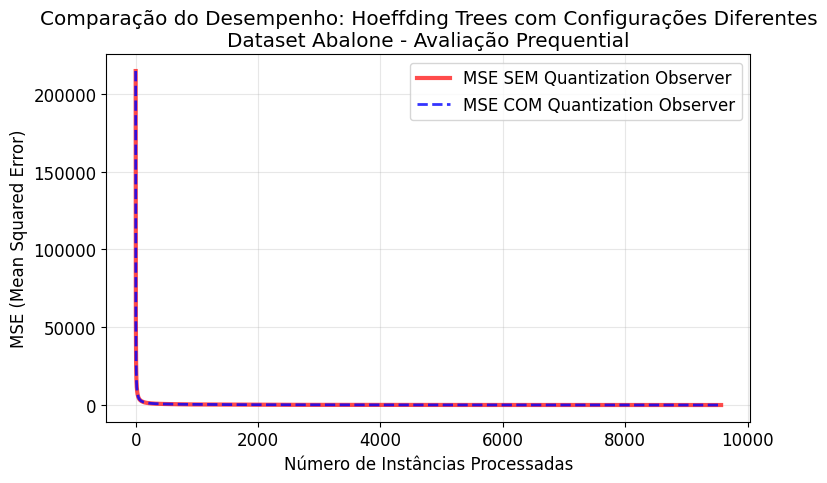

=== GRÁFICO GERADO COM SUCESSO ===

=== GRÁFICO DE USO DE MEMÓRIA ===


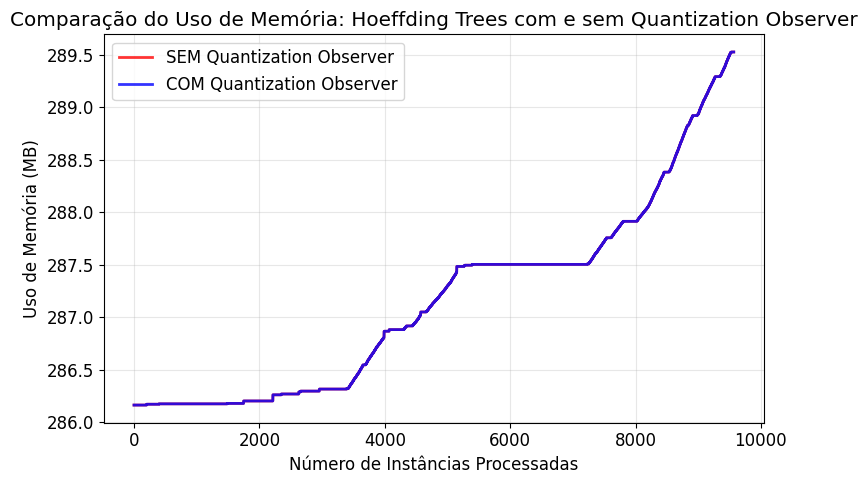


=== VISUALIZAÇÃO DAS ÁRVORES FINAIS ===

--- Árvore SEM Quantization Observer ---

SEM Quantization Observer:
Profundidade: 8
Número de nós: 65


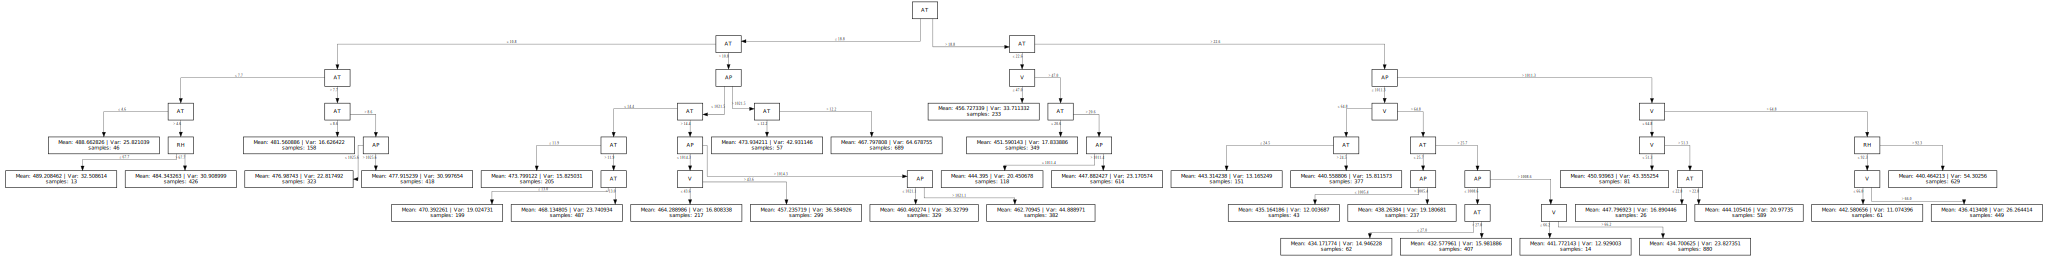


--- Árvore COM Quantization Observer ---

COM Quantization Observer:
Profundidade: 9
Número de nós: 63


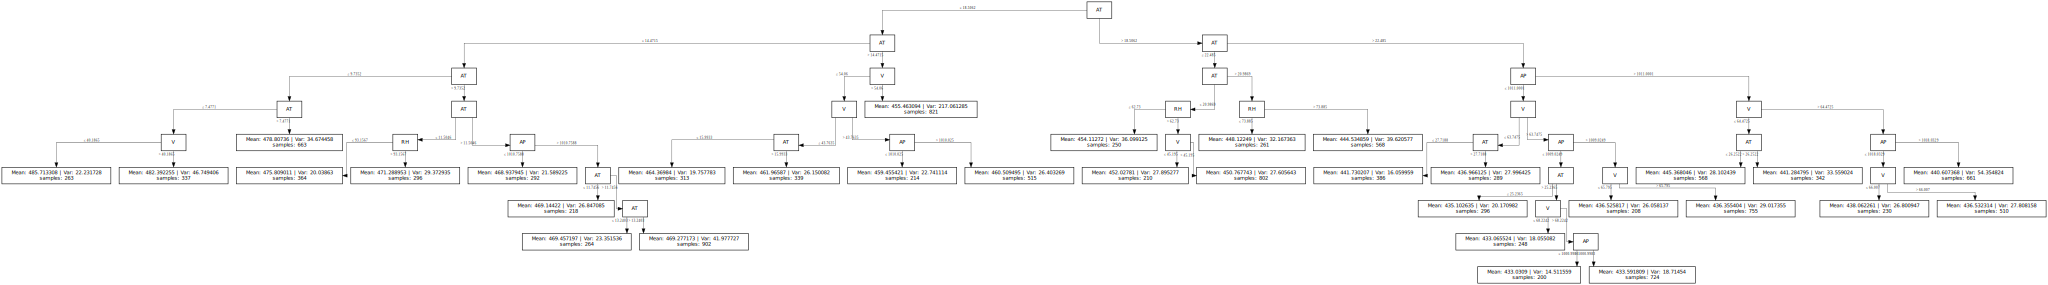


=== COMPARAÇÃO DETALHADA DAS ÁRVORES ===
ESTATÍSTICAS DAS ÁRVORES:
Métrica         SEM QO     COM QO     Diferença 
--------------------------------------------------
height          8          9                  +1
n_nodes         65         63                 -2
n_leaves        33         32                 -1
n_branches      32         31                 -1

=== GRÁFICO COMPARATIVO DAS ÁRVORES ===


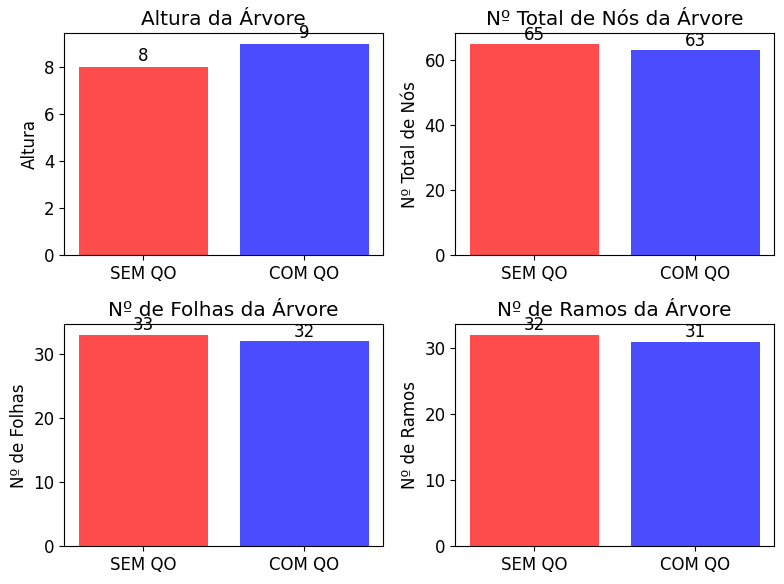


=== ANÁLISE DE EFICIÊNCIA ===
EFICIÊNCIA DO QUANTIZATION OBSERVER:
Redução no número de nós: +3.08%
SEM QO: 65 nós
COM QO: 63 nós

EFICIÊNCIA GERAL:
Redução de memória: -0.00%
Variação no MSE: -8.19%


In [18]:
# 3. DEFININDO OS MODELOS

print("\n=== CONFIGURANDO OS MODELOS ===")

# Pré-processamento apenas com StandardScaler para variáveis numéricas
preprocessor = preprocessing.StandardScaler()

# Modelo 1: Hoeffding Tree SEM Quantization Observer (configuração padrão)
model_without_qo = compose.Pipeline(
    #preprocessor,
    tree.HoeffdingTreeRegressor(
        #grace_period=100,
        delta=0.05,
        leaf_prediction='mean'
    )
)

# Modelo 2: Hoeffding Tree COM Quantization Observer
from river.tree.splitter import QOSplitter

model_with_qo = compose.Pipeline(
    #preprocessor,
    tree.HoeffdingTreeRegressor(
        #grace_period=100,
        delta=0.05,
        leaf_prediction='mean',
        splitter=QOSplitter()  # QUANTIZATION OBSERVER
    )
)

print("Modelos configurados!")
print("1. Hoeffding Tree SEM Quantization Observer")
print("2. Hoeffding Tree COM Quantization Observer")

# 4. FUNÇÃO PARA CONVERTER DATAFRAME PARA STREAM

def dataframe_to_stream(df, features, target):
    """Converte um DataFrame para um stream compatível com River"""
    for i, row in df.iterrows():
        x = {feature: row[feature] for feature in features}
        y = row[target]
        yield x, y

# 5. AVALIAÇÃO PREQUENTIAL E COLETA DE MÉTRICAS

print("\n=== INICIANDO AVALIAÇÃO PREQUENTIAL ===")

# Criando o stream a partir do DataFrame
stream = dataframe_to_stream(df, features, target)

# Métricas para acompanhar o desempenho
metric_without_qo = metrics.MSE()
metric_with_qo = metrics.MSE()

# Listas para armazenar os resultados
mse_without_qo = []     # MSE SEM QO
mse_with_qo = []        # MSE COM QO
memory_without_qo = []  # Memória SEM QO
memory_with_qo = []     # Memória COM QO
time_without_qo = []    # Tempo SEM QO
time_with_qo = []       # Tempo COM QO
instance_count = []

# Função para medir memória do processo
def get_process_memory():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # MB

print("Processando instâncias...")

# Avaliação prequential verdadeira (test-then-train)
for i, (x, y) in enumerate(stream):
    if i % 50 == 0:
        print(f"Processando instância {i}")

    # MEDIÇÃO DE TEMPO E MEMÓRIA PARA MODELO SEM QO
    start_time = time.time()
    pred_without = model_without_qo.predict_one(x)
    end_time = time.time()

    if pred_without is not None:
        metric_without_qo.update(y, pred_without)
        mse_without_qo.append(metric_without_qo.get())
    else:
        mse_without_qo.append(10.0)

    memory_without_qo.append(get_process_memory())
    time_without_qo.append(end_time - start_time)

    # MEDIÇÃO DE TEMPO E MEMÓRIA PARA MODELO COM QO
    start_time = time.time()
    pred_with = model_with_qo.predict_one(x)
    end_time = time.time()

    if pred_with is not None:
        metric_with_qo.update(y, pred_with)
        mse_with_qo.append(metric_with_qo.get())
    else:
        mse_with_qo.append(10.0)

    memory_with_qo.append(get_process_memory())
    time_with_qo.append(end_time - start_time)

    # FASE DE TREINO
    model_without_qo.learn_one(x, y)
    model_with_qo.learn_one(x, y)

    instance_count.append(i)

print(f"Avaliação prequential concluída! {len(instance_count)} instâncias processadas.")

# 6. VERIFICANDO SE OS VALORES SÃO DIFERENTES

print("\n=== VERIFICANDO VALORES ===")
print(f"Último MSE SEM QO: {mse_without_qo[-1]:.4f}")
print(f"Último MSE COM QO: {mse_with_qo[-1]:.4f}")

# Verificar se há diferenças nos valores
differences = np.array(mse_without_qo) - np.array(mse_with_qo)
max_diff = np.max(np.abs(differences))
print(f"Maior diferença absoluta entre as curvas: {max_diff:.6f}")

# 7. VISUALIZAÇÃO COMPARATIVA DOS RESULTADOS

print("\n=== GERANDO GRÁFICO COMPARATIVO ===")

# Criando o gráfico comparativo principal
plt.figure(figsize=(8, 5))

# Plotando as linhas com cores distintas e transparência
plt.plot(instance_count, mse_without_qo,
         label='MSE SEM Quantization Observer',
         linewidth=3,
         alpha=0.7,
         color='red')

plt.plot(instance_count, mse_with_qo,
         label='MSE COM Quantization Observer',
         linewidth=2,
         alpha=0.8,
         color='blue',
         linestyle='--')

plt.xlabel('Número de Instâncias Processadas')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Comparação do Desempenho: Hoeffding Trees com Configurações Diferentes\nDataset Abalone - Avaliação Prequential')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=== GRÁFICO GERADO COM SUCESSO ===")


# 9. GRÁFICO DE USO DE MEMÓRIA

print("\n=== GRÁFICO DE USO DE MEMÓRIA ===")

plt.figure(figsize=(8, 5))

plt.plot(instance_count, memory_without_qo,
         label='SEM Quantization Observer',
         linewidth=2,
         alpha=0.8,
         color='red')

plt.plot(instance_count, memory_with_qo,
         label='COM Quantization Observer',
         linewidth=2,
         alpha=0.8,
         color='blue')

plt.xlabel('Número de Instâncias Processadas')
plt.ylabel('Uso de Memória (MB)')
plt.title('Comparação do Uso de Memória: Hoeffding Trees com e sem Quantization Observer')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 12. VISUALIZAÇÃO DAS ÁRVORES FINAIS

print("\n=== VISUALIZAÇÃO DAS ÁRVORES FINAIS ===")

def visualize_tree(model, title):
    """Função para visualizar a árvore de decisão"""
    try:
        # Extrai a árvore do pipeline (se for um pipeline)
        if hasattr(model, 'steps'):
            tree_model = model.steps[list(model.steps.keys())[-1]]
        else:
            tree_model = model

        # Converte para Graphviz
        dot_data = tree_model.draw()

        # Exibe a árvore
        print(f"\n{title}:")
        print(f"Profundidade: {tree_model.height}")
        print(f"Número de nós: {tree_model.n_nodes}")
        return dot_data

    except Exception as e:
        print(f"Erro ao visualizar árvore: {e}")
        return None

# Visualizar árvore SEM QO
print("\n--- Árvore SEM Quantization Observer ---")
dot_without_qo = visualize_tree(model_without_qo, "SEM Quantization Observer")
if dot_without_qo:
    display(dot_without_qo)

# Visualizar árvore COM QO
print("\n--- Árvore COM Quantization Observer ---")
dot_with_qo = visualize_tree(model_with_qo, "COM Quantization Observer")
if dot_with_qo:
    display(dot_with_qo)

# 13. COMPARAÇÃO DETALHADA DAS ÁRVORES

print("\n=== COMPARAÇÃO DETALHADA DAS ÁRVORES ===")

def get_tree_stats(model):
    """Extrai estatísticas da árvore"""
    if hasattr(model, 'steps'):
        tree_model = model.steps[list(model.steps.keys())[-1]]
    else:
        tree_model = model

    return {
        'height': tree_model.height,
        'n_nodes': tree_model.n_nodes,
        'n_leaves': tree_model.n_leaves,
        'n_branches': tree_model.n_nodes - tree_model.n_leaves
    }

stats_without_qo = get_tree_stats(model_without_qo)
stats_with_qo = get_tree_stats(model_with_qo)

print("ESTATÍSTICAS DAS ÁRVORES:")
print(f"{'Métrica':<15} {'SEM QO':<10} {'COM QO':<10} {'Diferença':<10}")
print("-" * 50)
for key in ['height', 'n_nodes', 'n_leaves', 'n_branches']:
    diff = stats_with_qo[key] - stats_without_qo[key]
    print(f"{key:<15} {stats_without_qo[key]:<10} {stats_with_qo[key]:<10} {diff:>+10}")

# 14. GRÁFICO COMPARATIVO DAS ESTATÍSTICAS DAS ÁRVORES

print("\n=== GRÁFICO COMPARATIVO DAS ÁRVORES ===")

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.ravel()

metrics_names = ['Altura', 'Nº Total de Nós', 'Nº de Folhas', 'Nº de Ramos']
metrics_keys = ['height', 'n_nodes', 'n_leaves', 'n_branches']

for idx, (name, key) in enumerate(zip(metrics_names, metrics_keys)):
    values = [stats_without_qo[key], stats_with_qo[key]]
    labels = ['SEM QO', 'COM QO']

    bars = axes[idx].bar(labels, values, color=['red', 'blue'], alpha=0.7)
    axes[idx].set_title(f'{name} da Árvore')
    axes[idx].set_ylabel(name)

    # Adicionar valores nas barras
    for bar, value in zip(bars, values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                      f'{value}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 15. ANÁLISE DE EFICIÊNCIA

print("\n=== ANÁLISE DE EFICIÊNCIA ===")

# Calcular eficiência em termos de compactação
size_reduction = ((stats_without_qo['n_nodes'] - stats_with_qo['n_nodes']) / stats_without_qo['n_nodes']) * 100

print("EFICIÊNCIA DO QUANTIZATION OBSERVER:")
print(f"Redução no número de nós: {size_reduction:+.2f}%")
print(f"SEM QO: {stats_without_qo['n_nodes']} nós")
print(f"COM QO: {stats_with_qo['n_nodes']} nós")


# Eficiência memória vs desempenho
mem_efficiency = ((np.mean(memory_without_qo) - np.mean(memory_with_qo)) / np.mean(memory_without_qo)) * 100
mse_efficiency = ((mse_without_qo[-1] - mse_with_qo[-1]) / mse_without_qo[-1]) * 100

print(f"\nEFICIÊNCIA GERAL:")
print(f"Redução de memória: {mem_efficiency:+.2f}%")
print(f"Variação no MSE: {mse_efficiency:+.2f}%")
